#  图像变换
## 傅里叶变换

In [1]:
import cv2
import numpy as np
import copy as cp
from matplotlib import pyplot as plt
def imdisp(img,winName,sizeflag=cv2.WINDOW_NORMAL):
    if sizeflag==1:
        sizeflag=cv2.WINDOW_AUTOSIZE
    cv2.namedWindow(winName,sizeflag)
    cv2.imshow(winName,img) 
    cv2.waitKey(0)
    cv2.destroyWindow(winName)
color_ima=cv2.imread('../images/yaorenmao.jpeg')
gray_ima=cv2.cvtColor(color_ima,cv2.COLOR_BGR2GRAY)


### Numpy 中的傅里叶变换 
**np.fft.fft2()**

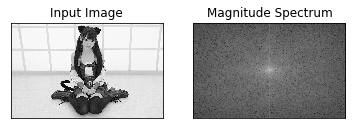

In [3]:
f = np.fft.fft2(gray_ima)
fshift = np.fft.fftshift(f)
# 这里构建振幅图的公式没学过
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(gray_ima, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

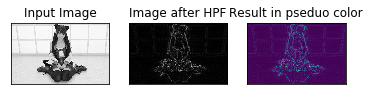

In [13]:
rows, cols = gray_ima.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
# 取绝对值
img_back = np.abs(img_back)
plt.subplot(131),plt.imshow(gray_ima, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in pseduo color'), plt.xticks([]), plt.yticks([])
plt.show()

##  openCV 中的傅里叶变换      
**cv2.dft() 和 cv2.idft()**  
第一个通道是结果的实数部分，第二个通道是结果的虚数部分。  
输入图像要首先转换成 np.float32 格式

In [11]:
int(rows/2)

300

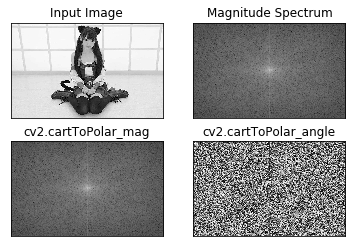

In [25]:
dft = cv2.dft(np.float32(gray_ima),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
mag,angle=cv2.cartToPolar(dft_shift[:,:,0],dft_shift[:,:,1]) # angle in radius
plt.subplot(221),plt.imshow(gray_ima, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow( 20*np.log(mag),'gray'), plt.title('cv2.cartToPolar_mag'), plt.xticks([]),plt.yticks([])
plt.subplot(224), plt.imshow( angle,'gray'), plt.title('cv2.cartToPolar_angle'), plt.xticks([]),plt.yticks([])
plt.show()

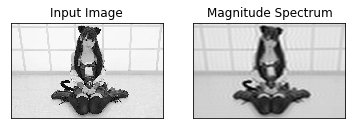

In [27]:
rows, cols = gray_ima.shape
crow,ccol = int(rows/2) , int(cols/2)
# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1
# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.subplot(121),plt.imshow(gray_ima, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### DFT 的性能优化
当数组的大小是 2 的指数时 DFT 效率最高。当数组的大小是 2， 3， 5 的倍数时效率也会很高
OpenCV 你必须自己手动补 0。但是 Numpy，你只需要指定 FFT 运算的大小，它会自动补 0。
**cv2.getOptimalDFTSize()** 确定最佳大小

In [33]:
nrows=cv2.getOptimalDFTSize(rows)
ncols=cv2.getOptimalDFTSize(cols)
print('origian size is ({},{}) \n best size is {} rows, {} cols'.format(rows, cols,nrows,ncols))

origian size is (600,960) 
 best size is 600 rows, 960 cols


In [35]:
nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = gray_ima
# opencv 补边方法
right = ncols - cols
bottom = nrows - rows
#just to avoid line breakup in PDF file
bordertype = cv2.BORDER_CONSTANT
nimg = cv2.copyMakeBorder(gray_ima,0,bottom,0,right,bordertype, value = 0)


In [42]:
%timeit fft1 = np.fft.fft2(gray_ima[:rows-7,:cols-7]) # 未补齐速度
%timeit fft1 = np.fft.fft2(nimg)
%timeit dft1= cv2.dft(np.float32(gray_ima[:rows-7,:cols-7]),flags=cv2.DFT_COMPLEX_OUTPUT)
%timeit dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)

10.3 ms ± 43.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.75 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.67 ms ± 392 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.23 ms ± 56.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


常用滤波器的傅里叶变换

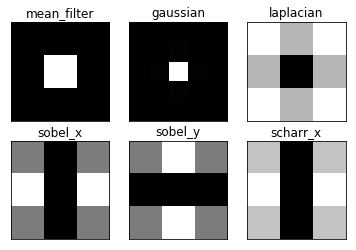

In [43]:

# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))
# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
#x.T 为矩阵转置
gaussian = x*x.T
# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
[-10,0,10],
[-3, 0, 3]])
# sobel in x direction
sobel_x= np.array([[-1, 0, 1],
[-2, 0, 2],
[-1, 0, 1]])
# sobel in y direction
sobel_y= np.array([[-1,-2,-1],
[0, 0, 0],
[1, 2, 1]])
# laplacian
laplacian=np.array([[0, 1, 0],
[1,-4, 1],
[0, 1, 0]])
filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()

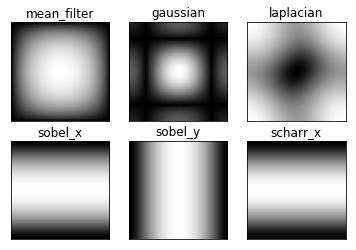

In [110]:
ptimg=np.ones((256,256))
f= np.fft.ifftshift(ptimg)
timg=np.abs(np.fft.ifft2(f))
filted =[cv2.filter2D(timg,-1,kernel) for kernel in filters]
fft_filters = [np.fft.fft2(x) for x in filted]
ft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in ft_shift]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])
plt.show()